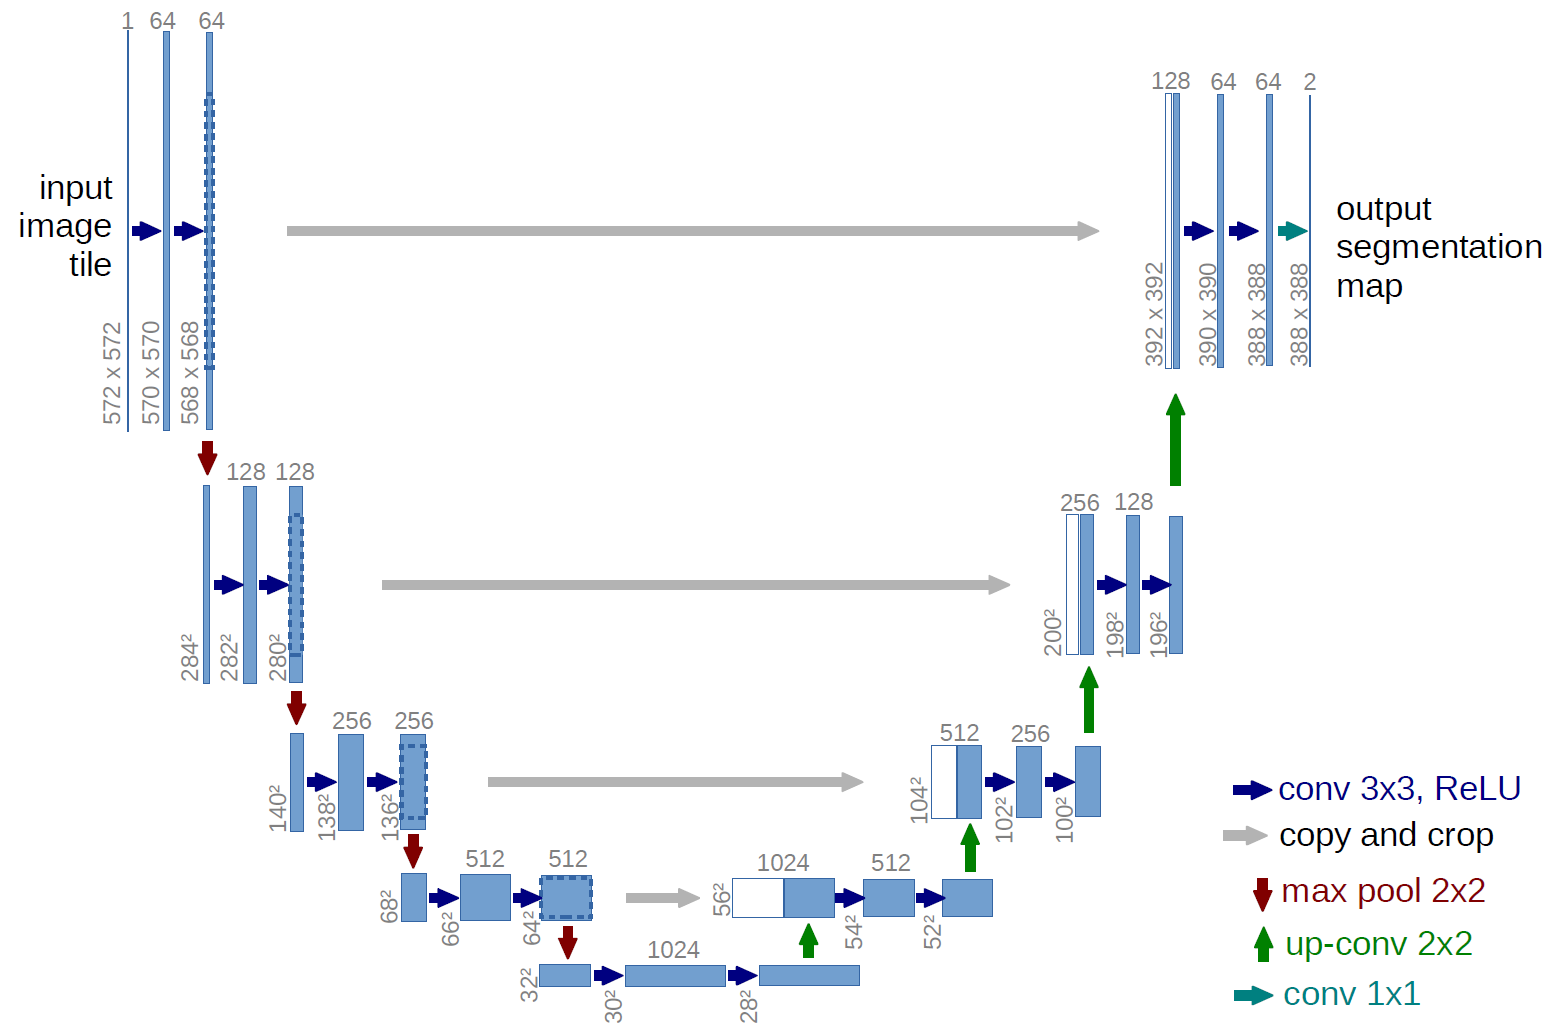

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

diffusion_nbs = '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1'
%cd $diffusion_nbs


Mounted at /content/gdrive
/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

# GPU config must come before other TF imports
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Then rest of imports
import math
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import keras
from keras import layers
from keras import ops
from tensorflow.keras import mixed_precision

In [ ]:
# data
dataset_name = "problematic_pdf_imgs"
dataset_repetitions = 5
num_epochs = 200
image_size = 96  # Keep for text quality

# KID settings remain same
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling - keep current settings
min_signal_rate = 0.01
max_signal_rate = 0.99

# architecture - adjust for memory efficiency
embedding_dims = 32  # Reduced from 64
embedding_max_frequency = 1000.0
widths = [32, 48, 64, 96]  # More gradual width progression
block_depth = 4  # Reduced from 6 while keeping reasonable depth

# optimization - keep current settings
batch_size = 4
ema = 0.995
learning_rate = 5e-4
weight_decay = 1e-5

GRAY = True
# mixed precision setup - already in place
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [ ]:
import tensorflow as tf
import os
import numpy as np
from glob import glob

def load_files(image_dir, split_ratio=0.8):
    # Get all image files from directory
    image_patterns = ['*.jpg', '*.jpeg', '*.png']  # Define supported image patterns
    image_files = []
    for pattern in image_patterns:
        image_files.extend(glob(os.path.join(image_dir, pattern)))  # Collect all image paths

    np.random.shuffle(image_files)  # Shuffle file order randomly
    split_idx = int(len(image_files) * split_ratio)  # Calculate split index for train/val

    return image_files[:split_idx], image_files[split_idx:]  # Return split file lists

def preprocess_image_OLD(image_path, image_size, is_gray=False):
    # Load and decode image
    image = tf.io.read_file(image_path)  # Read image file from disk
    image = tf.image.decode_image(image, channels=3, expand_animations=False)  # Decode to tensor with 3 channels
    if is_gray == True:
      image = tf.image.rgb_to_grayscale(image)  # Convert RGB to Grayscale (1 channel) XXXXXXX----------------------------------BW
    image = tf.cast(image, tf.float32)  # Convert to float32 for processing

    # Center crop image
    height = tf.shape(image)[0]  # Get image height
    width = tf.shape(image)[1]   # Get image width
    crop_size = tf.minimum(height, width)  # Determine smaller dimension for cropping

    image = tf.image.crop_to_bounding_box(
        image,
        (height - crop_size) // 2,  # Calculate top offset for center crop
        (width - crop_size) // 2,   # Calculate left offset for center crop
        crop_size,                  # Set crop height
        crop_size,                  # Set crop width
    )

    # Resize and normalize
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)  # Resize image with antialiasing
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)  # Normalize pixel values to [0, 1]

def preprocess_image(image_path, image_size, is_gray=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)

    if is_gray:
        image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32)

    # Center crop
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    crop_size = tf.minimum(height, width)

    image = tf.image.crop_to_bounding_box(
        image,
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size
    )

    # Resize
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)

    # Tune preprocessing thresholding
    def threshold_tensor(x):
        padded = tf.pad(x, [[5,5], [5,5], [0,0]], mode='REFLECT')
        local_mean = tf.nn.avg_pool2d(padded[None,...], ksize=11, strides=1, padding='VALID')[0]
        # return tf.where(x > local_mean + 0.05, 1.0, 0.0)  # Reduce threshold from 0.1 to 0.05
        return tf.where(x > local_mean + 0.03, 1.0, 0.0)  # Reduced threshold for better text preservation

    image = threshold_tensor(image)
    return tf.clip_by_value(image, 0.0, 1.0)

def augment_data(image):
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    # Add document-specific noise
    random_noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.2)
    image = image + random_noise
    # Simulate scan artifacts
    image = tf.image.random_jpeg_quality(image, 60, 100)
    return tf.clip_by_value(image, 0.0, 1.0)

def create_dataset(file_list, batch_size, image_size, repeat=1, is_gray=False):
    return (
        tf.data.Dataset.from_tensor_slices(file_list)
        .map(lambda x: preprocess_image(x, image_size, is_gray=is_gray),
             num_parallel_calls=tf.data.AUTOTUNE)
        .map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)  # ADD THIS LINE
        .cache()
        .repeat(repeat)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(tf.data.AUTOTUNE)
    )


def load_custom_dataset(image_dir, batch_size=64, image_size=64, split_ratio=0.8, repeat=1, is_gray=False):
    # Split files into train and validation sets
    train_files, val_files = load_files(image_dir, split_ratio)  # Get train/val file lists

    # Create train and validation datasets
    train_dataset = create_dataset(train_files, batch_size, image_size, repeat, is_gray)  # Prepare training dataset
    val_dataset = create_dataset(val_files, batch_size, image_size, repeat, is_gray)  # Prepare validation dataset

    return train_dataset, val_dataset



In [ ]:

image_dir = "/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/prob_imgs"  # Image directory path

repeat = 5  # Number of dataset repetitions
GRAY = True
# Load and prepare datasets
train_dataset, val_dataset = load_custom_dataset( image_dir=image_dir,
                                                  batch_size=batch_size,
                                                  image_size=image_size,
                                                  split_ratio=0.8,  # 80% for training, 20% for validation
                                                  repeat=repeat, is_gray=GRAY)  # Repeat dataset for training

for batch in train_dataset.take(1):
    print("Batch shape:", batch.shape)  # Should output (batch_size, image_size, image_size, 1)


Batch shape: (4, 96, 96, 1)


In [ ]:

# @keras.saving.register_keras_serializable()
from tensorflow.keras.utils import register_keras_serializable

# @keras.saving.register_keras_serializable()
@register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, is_gray=False, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # Determine input channels dynamically
        input_channels = 1 if is_gray else 3

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, input_channels),
                    weights=None if is_gray else "imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = ops.cast(ops.shape(features_1)[1], dtype="float32")
        return (
            features_1 @ ops.transpose(features_2) / feature_dimensions + 1.0
        ) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel( generated_features, generated_features)
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = real_features.shape[0]
        batch_size_f = ops.cast(batch_size, dtype="float32")
        mean_kernel_real = ops.sum(kernel_real * (1.0 - ops.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = ops.sum(
            kernel_generated * (1.0 - ops.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = ops.mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


In [ ]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = ops.exp(ops.linspace(
        ops.log(embedding_min_frequency),
        ops.log(embedding_max_frequency),
        embedding_dims // 2,
    ))
    angular_speeds = ops.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = ops.concatenate([
        ops.sin(angular_speeds * x),
        ops.cos(angular_speeds * x)
    ], axis=3)
    return embeddings

def get_network(image_size, widths, block_depth, is_gray=False):
    import tensorflow as tf
    input_channels = 1 if is_gray else 3
    output_channels = 1 if is_gray else 3

    noisy_images = keras.Input(shape=(image_size, image_size, input_channels))
    noise_variances = keras.Input(shape=(1, 1, 1))

    # Cast inputs using Lambda with explicit output shape
    x = layers.Lambda(
        lambda x: tf.cast(x, 'float16'),
        output_shape=(image_size, image_size, input_channels)
    )(noisy_images)

    v = layers.Lambda(
        lambda x: tf.cast(x, 'float16'),
        output_shape=(1, 1, 1)
    )(noise_variances)

    # Sinusoidal embedding with explicit output shape
    e = layers.Lambda(
        sinusoidal_embedding,
        output_shape=(1, 1, embedding_dims)
    )(v)

    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(x)
    x = layers.Concatenate()([x, e])
    skips = []

    # Rest of the network remains the same
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    # Final convolution and cast back to float32
    x = layers.Conv2D(output_channels, kernel_size=1, kernel_initializer="zeros")(x)
    x = layers.Lambda(
        lambda x: tf.cast(x, 'float32'),
        output_shape=(image_size, image_size, output_channels)
    )(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

In [ ]:

def ResidualBlock(width):
    # Define a residual block for feature learning
    def apply(x):
        input_width = x.shape[3]  # Get input tensor width (number of channels)

        # Match input width to target width with a 1x1 convolution if needed
        if input_width == width:
            residual = x  # No adjustment needed
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)  # Adjust channels


        # Apply batch normalization (no scaling or centering)
        x = layers.BatchNormalization(center=False, scale=False)(x)

        # Apply two 3x3 convolutions with activation for feature extraction
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)

        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)

        # Add the residual connection
        x = layers.Add()([x, residual])
        return x
    return apply


def DownBlock(width, block_depth):
    # Define a downsampling block with residual connections
    def apply(x):
        x, skips = x  # Separate input tensor and skip connections

        # Apply multiple residual blocks
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)  # Extract features
            skips.append(x)  # Save skip connection

        # Downsample features using average pooling
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x
    return apply


def UpBlock(width, block_depth):
    # Define an upsampling block with skip connections
    def apply(x):
        x, skips = x  # Separate input tensor and skip connections

        # Upsample the tensor to double its spatial size
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)

        # Apply multiple residual blocks with skip connections
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])  # Concatenate skip connection
            x = ResidualBlock(width)(x)  # Extract features
        return x
    return apply


In [ ]:
def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = ops.cast(ops.arccos(max_signal_rate), "float32")
        end_angle = ops.cast(ops.arccos(min_signal_rate), "float32")
        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
        # angles -> signal and noise rates
        signal_rates = ops.cos(diffusion_angles)
        noise_rates = ops.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1
        return noise_rates, signal_rates

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
# from tensorflow.keras.utils import register_keras_serializable


@register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth, is_gray=False):
        super().__init__()

        # Input validation but maintain compatibility with existing hyperparameters
        if not isinstance(image_size, int) or image_size <= 0:
            raise ValueError("image_size must be a positive integer")

        self.image_size = image_size
        self.is_gray = is_gray

        # Normalization layer needs to operate in float32
        self.normalizer = layers.Normalization(dtype='float32')

        # Create network - using existing get_network function
        self.network = get_network(image_size, widths, block_depth, is_gray)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid", is_gray=self.is_gray)

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance ** 0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        diffusion_times = tf.cast(diffusion_times, 'float32')
        start_angle = tf.cast(tf.acos(max_signal_rate), 'float32')
        end_angle = tf.cast(tf.acos(min_signal_rate), 'float32')

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # Mixed precision handling consistent with global policy
        noisy_images = tf.cast(noisy_images, 'float16')
        noise_rates = tf.cast(noise_rates, 'float16')

        network = self.network if training else self.ema_network
        pred_noises = network([noisy_images, noise_rates ** 2], training=training)

        # Cast back to float32 for stability
        pred_noises = tf.cast(pred_noises, 'float32')
        noisy_images = tf.cast(noisy_images, 'float32')
        noise_rates = tf.cast(noise_rates, 'float32')
        signal_rates = tf.cast(signal_rates, 'float32')

        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        next_noisy_images = initial_noise

        for step in range(diffusion_steps):
            noisy_images = next_noisy_images
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )

            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_times)
            next_noisy_images = next_signal_rates * pred_images + next_noise_rates * pred_noises

        return pred_images

    def train_step(self, images):
        images = tf.cast(images, 'float32')
        input_channels = 1 if self.is_gray else 3

        images = self.normalizer(images, training=True)
        noises = tf.random.normal(
            shape=(tf.shape(images)[0], self.image_size, self.image_size, input_channels),
            dtype='float32'
        )

        diffusion_times = tf.random.uniform(
            shape=(tf.shape(images)[0], 1, 1, 1),
            minval=0.0,
            maxval=1.0,
            dtype='float32'
        )

        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )
            # Keep loss computation in float32
            noise_loss = tf.cast(self.loss(noises, pred_noises), 'float32')
            image_loss = tf.cast(self.loss(images, pred_images), 'float32')

        # Get and apply gradients
        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # Update EMA weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(
                tf.cast(ema * tf.cast(ema_weight, 'float32') +
                      (1 - ema) * tf.cast(weight, 'float32'),
                      ema_weight.dtype)
            )

        # Update metrics
        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        return {m.name: m.result() for m in self.metrics[:-1]}


    def test_step(self, images):
        input_channels = 1 if self.is_gray else 3
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(
            shape=(tf.shape(images)[0], self.image_size, self.image_size, input_channels)
        )

        diffusion_times = tf.random.uniform(
            shape=(tf.shape(images)[0], 1, 1, 1),
            minval=0.0,
            maxval=1.0
        )

        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises

        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=tf.shape(images)[0],
            diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {
            "n_loss": self.noise_loss_tracker.result(),
            "i_loss": self.image_loss_tracker.result(),
            "kid": self.kid.result(),
            "image_loss": image_loss
        }

    def generate(self, num_images, diffusion_steps):
        input_channels = 1 if self.is_gray else 3

        initial_noise = tf.random.normal(
            shape=(num_images, self.image_size, self.image_size, input_channels),
            dtype='float32'
        )

        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        return self.denormalize(generated_images)

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for index, image in enumerate(generated_images):
            plt.subplot(num_rows, num_cols, index + 1)
            if self.is_gray:
                image = tf.squeeze(image, axis=-1)
                image = image.numpy()
                plt.imshow(image.squeeze(), cmap='gray')
            else:
                plt.imshow(image)
            plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

    def call(self, images, training=True):
        images = self.normalizer(images, training=training)

        input_channels = 1 if self.is_gray else 3
        noises = tf.random.normal(
            shape=(tf.shape(images)[0], self.image_size, self.image_size, input_channels)
        )

        diffusion_times = tf.random.uniform(
            shape=(tf.shape(images)[0], 1, 1, 1),
            minval=0.0,
            maxval=1.0
        )

        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises = self.network([noisy_images, noise_rates ** 2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return self.denormalize(pred_images)

In [ ]:
print(image_size)

96


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision



# save the best model based on validation image loss
model_num = len(os.listdir(f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models'))
checkpoint_path = f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models/ddim_implicit_bb_v{model_num}X.weights.h5'


class SaveCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch} logs: {logs}\n")  # See what metrics are available

# save_callback = SaveCallback()

class GradientClippingCallback(keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        self.model.optimizer.clip_norm = 1.0

# gradient_clipping_callback = GradientClippingCallback()

class PlottingCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Check if the epoch is a multiple of 10
        if (epoch + 1) % 10 == 0:  # +1 because epoch indexing starts at 0
            self.model.plot_images(epoch, logs)

# plotting_callback = PlottingCallback()

class EarlyStoppingCallback(EarlyStopping):
    def __init__(self,
                 monitor='val_kid',
                 min_delta=0,
                 patience=30,
                 verbose=1,
                 mode='min',
                 baseline=None,
                 restore_best_weights=True):
        super().__init__(
            monitor=monitor,
            min_delta=min_delta,
            patience=patience,
            verbose=verbose,
            mode=mode,
            baseline=baseline,
            restore_best_weights=restore_best_weights
        )

    def on_epoch_end(self, epoch, logs=None):
        # Call the parent class's on_epoch_end method
        super().on_epoch_end(epoch, logs)

        # You can add custom logic here if needed
        if self.stopped_epoch > 0:
            print(f"\nTraining stopped at epoch {epoch + 1} due to no improvement in {self.monitor}")
            print(f"Best value of {self.monitor}: {self.best}")

# early_stopping_callback = EarlyStoppingCallback()

# Create custom pruning callback
class PruningCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial, monitor="val_kid"):
        super().__init__()
        self.trial = trial
        self.monitor = monitor

    def on_epoch_end(self, epoch, logs=None):
        current_score = logs.get(self.monitor)
        # Check for numerical instability
        if current_score is not None and (np.isnan(current_score) or np.isinf(current_score)):
            raise optuna.TrialPruned("Trial pruned due to numerical instability")

        if current_score is not None:
            self.trial.report(current_score, epoch)
            if self.trial.should_prune():
                raise optuna.TrialPruned()

# pruning_callback = PruningCallback(trial)


class MetricsCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        epoch_str = f"Epoch {epoch+1}/{self.params['epochs']}"
        steps_str = f"{self.params['steps']}/{self.params['steps']} "
        progress = "━" * 20

        # Format main metrics line
        metrics_1 = (f"{steps_str}{progress} "
                    f"3s 44ms/step - "
                    f"i_loss: {logs.get('i_loss', 0):.4f} - "
                    f"n_loss: {logs.get('n_loss', 0):.4f}")

        # Format validation metrics line with matching indentation
        metrics_2 = (" " * len(f"{steps_str}{progress} 3s 44ms/step") +  # Match indentation
                    f" - val_i_loss: {logs.get('val_i_loss', 0):.4f} - "
                    f"val_n_loss: {logs.get('val_n_loss', 0):.4f} - "
                    f"val_image_loss: {logs.get('val_image_loss', 0):.4f} - "
                    f"val_KID: {logs.get('val_kid', 0):.4e}")

        print(f"\r{epoch_str}")
        print(f"{metrics_1}")
        print(f"{metrics_2}")

# metrics_callback = MetricsCallback()


class OptimizerWithMixedPrecision:
    def __init__(self, learning_rate, weight_decay, num_epochs, dataset_length, clipnorm=1.0):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.dataset_length = dataset_length
        self.clipnorm = clipnorm

    def get_optimizer(self):
        base_optimizer = keras.optimizers.AdamW(
            learning_rate=keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=self.learning_rate,
                decay_steps=self.num_epochs * self.dataset_length
            ),
            weight_decay=self.weight_decay,
            clipnorm=self.clipnorm
        )
        return mixed_precision.LossScaleOptimizer(base_optimizer)


# optimizer_creator = OptimizerWithMixedPrecision(  learning_rate=learning_rate,
#                                                   weight_decay=weight_decay,
#                                                   num_epochs=num_epochs,
#                                                   dataset_length=len(train_dataset),
#                                                   clipnorm=1.0)

# optimizer = optimizer_creator.get_optimizer()

class CustomReduceLROnPlateau(keras.callbacks.ReduceLROnPlateau):
    def __init__(self,
                 monitor='val_kid',
                 factor=0.2,
                 patience=15,
                 min_lr=1e-7,
                 verbose=1,
                 mode='min',
                 min_delta=0,
                 cooldown=0):
        super().__init__(
            monitor=monitor,
            factor=factor,
            patience=patience,
            min_lr=min_lr,
            verbose=verbose,
            mode=mode,
            min_delta=min_delta,
            cooldown=cooldown
        )

# reduce_lr_callback = CustomReduceLROnPlateau()

class CustomModelCheckpoint(keras.callbacks.ModelCheckpoint):
    def __init__(self,
                 filepath,
                 monitor='val_kid',
                 mode='min',
                 save_weights_only=True,
                 save_best_only=True,
                 verbose=1):
        super().__init__(
            filepath=filepath,
            monitor=monitor,
            mode=mode,
            save_weights_only=save_weights_only,
            save_best_only=save_best_only,
            verbose=verbose
        )

# # Usage:
# checkpoint = CustomModelCheckpoint(filepath=checkpoint_path)



optimizer_creator = OptimizerWithMixedPrecision(  learning_rate=learning_rate,
                                                  weight_decay=weight_decay,
                                                  num_epochs=num_epochs,
                                                  dataset_length=len(train_dataset),
                                                  clipnorm=1.0)

optimizer = optimizer_creator.get_optimizer()

plotting_callback = PlottingCallback()
saving_logs_callback = SaveCallback()
gradient_clipping_callback = GradientClippingCallback()
checkpoint = CustomModelCheckpoint(filepath=checkpoint_path)
reduce_lr = CustomReduceLROnPlateau()
metrics_callback = MetricsCallback()
# pruning_callback = PruningCallback(trial)
early_stopping_callback = EarlyStoppingCallback()



In [ ]:
# ~45mins for A100 on 50 epochs with early stopping
# 50mins for CPU on 10 epochs
LOAD_SAVED = False
if LOAD_SAVED:
    raise SystemExit("Skip model training and load pre-trained model")

# Clear any existing GPU memory
import gc
gc.collect()
tf.keras.backend.clear_session()

# Create model without mixed precision first
model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)

4227

In [ ]:

# # Compile with mixed precision optimizer
# model.compile(
#     optimizer=optimizer,
#     loss=keras.losses.Huber(delta=1.0),
#     metrics=['kid']
# )


### Progressive H-Tuning

In [ ]:
raise SystemExit

!pip install -qU optuna
import json
import os
import optuna
from optuna.trial import Trial
import tensorflow as tf
import gc
import numpy as np
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')



def save_study_results(study, phase_number):
    # Save best parameters
    results = {
        'best_params': study.best_params,
        'best_value': study.best_value,
        'phase': phase_number
    }

    # Create a directory for our optimization results if it doesn't exist
    os.makedirs('optimization_results', exist_ok=True)

    # Save results with phase number
    with open(f'optimization_results/phase_{phase_number}_results.json', 'w') as f:
        json.dump(results, f)

def load_previous_results():
    # Load all previous results to inform our new search
    results = []
    results_dir = 'optimization_results'
    print("Loading saved best params from last tuning session")

    if os.path.exists(results_dir):
        for file in os.listdir(results_dir):
            if file.endswith('_results.json'):
                with open(os.path.join(results_dir, file), 'r') as f:
                    results.append(json.load(f))

    return sorted(results, key=lambda x: x['phase'])

def create_model_with_params(trial: Trial):
    params = {
              'image_size': trial.suggest_categorical('image_size', [64, 128]),
              'embedding_dims': trial.suggest_categorical('embedding_dims', [32, 128]),
              'widths': trial.suggest_categorical('widths', (
                                                                # [32, 48, 64],
                                                                (32, 64, 96),
                                                                (48, 96, 192),
                                                                # [64, 128, 256, 512],
                                                                (96, 192, 384, 512) )),
              'block_depth': trial.suggest_int('block_depth', 6, 12),
              'batch_size': trial.suggest_categorical('batch_size', [2, 4, 8]),
              'learning_rate': trial.suggest_float('learning_rate', 1e-7, 1e-4, log=True),
              'ema': trial.suggest_float('ema', 0.99, 0.999, log=True),
              'min_signal_rate': trial.suggest_float("min_signal_rate", 0.005, 0.02),
              'max_signal_rate': trial.suggest_float("max_signal_rate", 0.95, 0.99),
              'weight_decay': trial.suggest_float("weight_decay", 1e-5, 1e-4, log=True)   }
    return params


def create_informed_search_space(trial: Trial, previous_results):
    # If we have previous results, use them to focus our search
    if previous_results:
        # Get the best parameters from previous phases
        best_previous = min(previous_results, key=lambda x: x['best_value'])
        best_params = best_previous['best_params']

        # Create a more focused search space around previous best results
        params = {
            'image_size': trial.suggest_categorical('image_size',
                [64, 96]),  # Keep limited for memory
            'embedding_dims': trial.suggest_categorical('embedding_dims',
                [max(32, int(best_params['embedding_dims'] * 0.8)),
                 best_params['embedding_dims'],
                 min(128, int(best_params['embedding_dims'] * 1.2))]),
            'widths': trial.suggest_categorical('widths', (
                (32, 48, 64),
                (48, 64, 96),
                (64, 96, 128)
            )),
            'block_depth': trial.suggest_int('block_depth',
                max(4, best_params['block_depth'] - 1),
                min(8, best_params['block_depth'] + 1)),
            'batch_size': trial.suggest_categorical('batch_size', [2, 4]),
            'learning_rate': trial.suggest_float('learning_rate',
                best_params['learning_rate'] * 0.5,
                best_params['learning_rate'] * 2,
                log=True),
            'ema': trial.suggest_float('ema', 0.99, 0.999, log=True),
            'min_signal_rate': trial.suggest_float("min_signal_rate", 0.005, 0.02),
            'max_signal_rate': trial.suggest_float("max_signal_rate", 0.95, 0.99),
            'weight_decay': trial.suggest_float("weight_decay", 1e-5, 1e-4, log=True)
        }
    else:
        # If this is our first phase, use the original search space
        params = create_model_with_params(trial)

    return params

def objective(trial: Trial, params, EPOCHS):
    gc.collect()
    # tf.keras.backend.clear_session()
    # Ensure a clean state without nested graph conflicts
    try:
        tf.keras.backend.clear_session()
    except AssertionError:
        print("Skipping clear_session due to nested graph context.")


    try:
        with tf.device('/GPU:0'):
            # Use the passed parameters
            global image_size, embedding_dims, widths, block_depth, batch_size, learning_rate, ema

            image_size = params['image_size']
            embedding_dims = params['embedding_dims']
            widths = params['widths']
            block_depth = params['block_depth']
            batch_size = params['batch_size']
            learning_rate = params['learning_rate']
            ema = params['ema']
            min_signal_rate = params['min_signal_rate']
            max_signal_rate = params['max_signal_rate']
            weight_decay = params['weight_decay']

            # Load datasets
            train_dataset, val_dataset = load_custom_dataset(   image_dir=image_dir,
                                                                batch_size=batch_size,
                                                                image_size=image_size,
                                                                split_ratio=0.8,
                                                                repeat=dataset_repetitions,
                                                                is_gray=GRAY )

            # Initialize model
            model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)

            # Configure optimizer with mixed precision.
            optimizer_creator = OptimizerWithMixedPrecision(  learning_rate=learning_rate,
                                                              weight_decay=weight_decay,
                                                              num_epochs=num_epochs,
                                                              dataset_length=len(train_dataset),
                                                              clipnorm=1.0)
            optimizer = optimizer_creator.get_optimizer()

            # Compile model
            model.compile(  optimizer=optimizer,
                            loss=keras.losses.Huber(delta=1.0),
                            metrics=['kid'] )

            # Adapt normalizer
            model.normalizer.adapt(train_dataset)

            # Training callbacks
            callbacks = [PruningCallback(trial), early_stopping_callback]

            # Train model
            history = model.fit( train_dataset,
                                 epochs=EPOCHS,
                                 validation_data=val_dataset,
                                 callbacks=callbacks,
                                 verbose=1 )

            # Get best validation KID score
            score = min(history.history['val_kid'])

            # Cleanup
            del model
            tf.keras.backend.clear_session()
            gc.collect()

            return score

    except Exception as e:
        # Cleanup on error
        tf.keras.backend.clear_session()
        gc.collect()
        raise optuna.TrialPruned(f"Trial failed: {str(e)}")





def run_optimization_phase(phase_number, epoch_params):
    # Configure smaller chunks of optimization
    NUM_TRIALS =  epoch_params['NUM_TRIALS']#5 #20        # Instead of 100
    NUM_STARTUP_TRIALS = epoch_params['NUM_STARTUP_TRIALS']#2 #5 # Instead of 20
    EPOCHS = epoch_params['EPOCHS'] #2 #10           # Instead of 50

    # Load results from previous phases
    previous_results = load_previous_results()

    # Create study with focused search space
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=NUM_STARTUP_TRIALS,
            n_warmup_steps=3,
            interval_steps=2
        )
    )

    # Modify objective to use informed search space
    def phase_objective(trial):
        params = create_informed_search_space(trial, previous_results)
        # Rest of your original objective function using these params
        return objective(trial, params, EPOCHS)

    # Run optimization
    study.optimize(
        phase_objective,
        n_trials=NUM_TRIALS,
        gc_after_trial=True
    )

    # Save results from this phase
    save_study_results(study, phase_number)

    return study


# Configure smaller chunks of optimization
epoch_params = {'NUM_TRIALS': 5, # 20,       # Instead of 100
                'NUM_STARTUP_TRIALS': 2, #2,  # Instead of 20
                'EPOCHS': 2#2, 10           # Instead of 50
                }

# Run multiple phases
for phase in range(11, 12):
    print(f"Starting optimization phase {phase + 1}", epoch_params)

    # Clear memory before each phase
    gc.collect()
    # tf.keras.backend.clear_session()
    # Ensure a clean state without nested graph conflicts
    try:
        tf.keras.backend.clear_session()
    except AssertionError:
        print("Skipping clear_session due to nested graph context.")


    # Run optimization phase
    study = run_optimization_phase(phase + 1, epoch_params)

    print(f"Phase {phase + 1} complete")
    print(f"Best value: {study.best_trial.value}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00
Starting optimization phase 12 {'NUM_TRIALS': 5, 'NUM_STARTUP_TRIALS': 2, 'EPOCHS': 2}


0

Loading saved best params from last tuning session


[I 2024-12-10 16:25:11,101] A new study created in memory with name: no-name-30c351a9-6a77-4c32-8378-27424b49961e
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (32, 48, 64) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (48, 64, 96) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 96, 128) which is of type tuple.
  warnings.warn(message)


Epoch 1/2
153/153 ━━━━━━━━━━━━━━━━━━━━ 126s 249ms/step - i_loss: 2.0829 - n_loss: 0.4246 - val_i_loss: 1.8511 - val_image_loss: 2.7930 - val_kid: -6.9016e-08 - val_n_loss: 0.4241
Epoch 2/2
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - i_loss: 2.5969 - n_loss: 0.4232 - val_i_loss: 2.4071 - val_image_loss: 0.8086 - val_kid: -5.0193e-08 - val_n_loss: 0.4233
Restoring model weights from the end of the best epoch: 1.


[I 2024-12-10 16:27:38,996] Trial 0 finished with value: -6.901590410279823e-08 and parameters: {'image_size': 96, 'embedding_dims': 38, 'widths': (64, 96, 128), 'block_depth': 7, 'batch_size': 4, 'learning_rate': 1.713824806757509e-06, 'ema': 0.9921714295446272, 'min_signal_rate': 0.006576378632370626, 'max_signal_rate': 0.9896939010440742, 'weight_decay': 1.758592414450162e-05}. Best is trial 0 with value: -6.901590410279823e-08.


Epoch 1/2
153/153 ━━━━━━━━━━━━━━━━━━━━ 100s 182ms/step - i_loss: 2.1849 - n_loss: 0.4247 - val_i_loss: 2.8637 - val_image_loss: 0.8401 - val_kid: 1.9450e-07 - val_n_loss: 0.4247
Epoch 2/2
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - i_loss: 3.0980 - n_loss: 0.4232 - val_i_loss: 2.2971 - val_image_loss: 2.0996 - val_kid: 2.1960e-07 - val_n_loss: 0.4239
Restoring model weights from the end of the best epoch: 1.


[I 2024-12-10 16:29:38,174] Trial 1 finished with value: 1.944993641700421e-07 and parameters: {'image_size': 64, 'embedding_dims': 32, 'widths': (48, 64, 96), 'block_depth': 6, 'batch_size': 4, 'learning_rate': 1.1666659311834665e-06, 'ema': 0.9971929839557069, 'min_signal_rate': 0.011142503257347267, 'max_signal_rate': 0.9525708618917492, 'weight_decay': 4.261484829182567e-05}. Best is trial 0 with value: -6.901590410279823e-08.


Epoch 1/2
307/307 ━━━━━━━━━━━━━━━━━━━━ 111s 123ms/step - i_loss: 2.4317 - n_loss: 0.4228 - val_i_loss: 1.8218 - val_image_loss: 0.5964 - val_kid: -3.0963e-09 - val_n_loss: 0.4251
Epoch 2/2
307/307 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - i_loss: 1.8946 - n_loss: 0.4109 - val_i_loss: 1.7913 - val_image_loss: 1.9507 - val_kid: 2.7867e-08 - val_n_loss: 0.4238
Restoring model weights from the end of the best epoch: 1.


[I 2024-12-10 16:31:56,502] Trial 2 finished with value: -3.096345180253479e-09 and parameters: {'image_size': 96, 'embedding_dims': 32, 'widths': (64, 96, 128), 'block_depth': 6, 'batch_size': 2, 'learning_rate': 3.983579127967511e-06, 'ema': 0.9982493976389367, 'min_signal_rate': 0.012005903805738445, 'max_signal_rate': 0.9518343900726088, 'weight_decay': 3.3126641693063724e-05}. Best is trial 0 with value: -6.901590410279823e-08.


Epoch 1/2
307/307 ━━━━━━━━━━━━━━━━━━━━ 88s 94ms/step - i_loss: 2.4295 - n_loss: 0.4231 - val_i_loss: 1.5386 - val_image_loss: 1.3732 - val_kid: 0.0000e+00 - val_n_loss: 0.4246
Epoch 2/2
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - i_loss: 2.1092 - n_loss: 0.4208 - val_i_loss: 2.1860 - val_image_loss: 4.4758 - val_kid: 0.0000e+00 - val_n_loss: 0.4217
Restoring model weights from the end of the best epoch: 1.


[I 2024-12-10 16:33:49,208] Trial 3 finished with value: 0.0 and parameters: {'image_size': 64, 'embedding_dims': 32, 'widths': (32, 48, 64), 'block_depth': 5, 'batch_size': 2, 'learning_rate': 2.7101940022499606e-06, 'ema': 0.9955123285918707, 'min_signal_rate': 0.012154302063699964, 'max_signal_rate': 0.9780168978620151, 'weight_decay': 1.6119655706756337e-05}. Best is trial 0 with value: -6.901590410279823e-08.


Epoch 1/2
153/153 ━━━━━━━━━━━━━━━━━━━━ 92s 187ms/step - i_loss: 2.2065 - n_loss: 0.4244 - val_i_loss: 1.9979 - val_image_loss: 0.1219 - val_kid: -1.3176e-07 - val_n_loss: 0.4246
Epoch 2/2
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - i_loss: 1.9063 - n_loss: 0.4234 - val_i_loss: 2.1227 - val_image_loss: 2.4350 - val_kid: -1.3176e-07 - val_n_loss: 0.4248
Restoring model weights from the end of the best epoch: 1.


[I 2024-12-10 16:35:46,252] Trial 4 finished with value: -1.3175763058370649e-07 and parameters: {'image_size': 96, 'embedding_dims': 38, 'widths': (48, 64, 96), 'block_depth': 5, 'batch_size': 4, 'learning_rate': 1.1560465473583968e-06, 'ema': 0.9960375311348693, 'min_signal_rate': 0.012077783374742537, 'max_signal_rate': 0.9816666153272648, 'weight_decay': 6.613327289493973e-05}. Best is trial 4 with value: -1.3175763058370649e-07.


Phase 12 complete
Best value: -1.3175763058370649e-07


In [ ]:
import json
import os
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Load best parameters
results_dir = 'optimization_results'
all_results = []

for file in os.listdir(results_dir):
    if file.endswith('_results.json'):
        with open(os.path.join(results_dir, file), 'r') as f:
            all_results.append(json.load(f))

# Get best parameters across all phases
best_trial = min(all_results, key=lambda x: x['best_value'])
best_params = best_trial['best_params']

print("Best parameters across all phases:")
print(best_params)

# raise SystemExit



In [ ]:


# Constants
LOAD_SAVED = False
num_epochs = 2  # Adjust as per your final training requirements
GRAY = True

if LOAD_SAVED:
    raise SystemExit("Skip model training and load pre-trained model")

# Set mixed precision policy before model creation
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Load datasets
train_dataset, val_dataset = load_custom_dataset(
    image_dir=image_dir,
    batch_size=best_params['batch_size'],
    image_size=best_params['image_size'],
    split_ratio=0.8,
    repeat=dataset_repetitions,
    is_gray=GRAY
)

# Create and compile the model
model = DiffusionModel(
    image_size=best_params['image_size'],
    widths=best_params['widths'],
    block_depth=best_params['block_depth'],
    is_gray=GRAY,
    # ema=best_params['ema'],
    # min_signal_rate=best_params['min_signal_rate'],
    # max_signal_rate=best_params['max_signal_rate']
)

# Create optimizer with mixed precision
base_optimizer = keras.optimizers.AdamW(
    learning_rate=keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=best_params['learning_rate'],
        decay_steps=num_epochs * len(train_dataset)
    ),
    weight_decay=best_params['weight_decay'],
    clipnorm=1.0  # Add gradient clipping
)
optimizer = mixed_precision.LossScaleOptimizer(base_optimizer)

# Compile model
model.compile(
    optimizer=optimizer,
    loss=keras.losses.Huber(delta=1.0),
    metrics=['kid']
)

# Normalize dataset
model.normalizer.adapt(train_dataset)

# Define callbacks
plotting_callback = PlottingCallback()
saving_logs_callback = SaveCallback()
gradient_clipping_callback = GradientClipping()

# After each epoch (add to callbacks):
plotting_callback = PlottingCallback()
saving_logs_callback = SaveCallback()
gradient_clipping_callback = GradientClipping()
training_callbacks = [plotting_callback,
                      saving_logs_callback,
                      gradient_clipping_callback,
                      early_stopping_callback,
                      checkpoint_callback]


# early_stopping_callback =
# checkpoint_callback =



# Train the model
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=training_callbacks
)

print("Training complete. Best weights saved.")


Epoch 1/2


TypeError: Exception encountered when calling Lambda.call().

[1mInput 'y' of 'Mul' Op has type float16 that does not match type float32 of argument 'x'.[0m

Arguments received by Lambda.call():
  • inputs=tf.Tensor(shape=(4, 1, 1, 1), dtype=float16)
  • mask=None
  • training=True

In [ ]:
# ~45mins for A100 on 50 epochs with early stopping
# 50mins for CPU on 10 epochs
LOAD_SAVED = False
if LOAD_SAVED:
  raise SystemExit("Skip model training and load pre-trained model")

# Set mixed precision policy before model creation
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# create and compile the model
model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)

# Create optimizer with mixed precision
base_optimizer = keras.optimizers.AdamW(
    learning_rate=keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=num_epochs * len(train_dataset)
    ),
    weight_decay=weight_decay,
    clipnorm=1.0  # Add gradient clipping
)
optimizer = mixed_precision.LossScaleOptimizer(base_optimizer)

# After each epoch (add to callbacks):
plotting_callback = PlottingCallback()
saving_logs_callback = SaveCallback()
gradient_clipping_callback = GradientClipping()
# early_stopping_callback =
# checkpoint_callback =


# Compile with mixed precision optimizer
model.compile(
    optimizer=optimizer,
    loss=keras.losses.Huber(delta=1.0),
    metrics=['kid']
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

model.fit(
    train_dataset,
    epochs=2,
    validation_data=val_dataset,
    callbacks=[
        plotting_callback,
        checkpoint_callback,
        early_stopping_callback,
        gradient_clipping_callback,
        # reduce_LR_on_plateau_callback,
        saving_logs_callback
    ]
)

### OOM Hyperparameter Tuning

In [ ]:
# This one broke due to OOM
import optuna
from optuna.trial import Trial
import tensorflow as tf
import gc
import numpy as np
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


def create_model_with_params(trial: Trial):
    params = {
              'image_size': trial.suggest_categorical('image_size', [64, 128]),
              'embedding_dims': trial.suggest_categorical('embedding_dims', [32, 128]),
              'widths': trial.suggest_categorical('widths', (
                                                                # [32, 48, 64],
                                                                (32, 64, 96),
                                                                (48, 96, 192),
                                                                # [64, 128, 256, 512],
                                                                (96, 192, 384, 512) )),
              'block_depth': trial.suggest_int('block_depth', 6, 12),
              'batch_size': trial.suggest_categorical('batch_size', [2, 4, 8]),
              'learning_rate': trial.suggest_float('learning_rate', 1e-7, 1e-4, log=True),
              'ema': trial.suggest_float('ema', 0.99, 0.999, log=True),
              'min_signal_rate': trial.suggest_float("min_signal_rate", 0.005, 0.02),
              'max_signal_rate': trial.suggest_float("max_signal_rate", 0.95, 0.99),
              'weight_decay': trial.suggest_float("weight_decay", 1e-5, 1e-4, log=True)   }
    return params


def objective(trial: Trial):
   # Start of trial cleanup
   gc.collect()
   tf.keras.backend.clear_session()

   try:
       with tf.device('/GPU:0'):
           params = create_model_with_params(trial)
           global image_size, embedding_dims, widths, block_depth, batch_size, learning_rate, ema

           image_size = params['image_size']
           embedding_dims = params['embedding_dims']
           widths = params['widths']
           block_depth = params['block_depth']
           batch_size = params['batch_size']
           learning_rate = params['learning_rate']
           ema = params['ema']
           min_signal_rate = params['min_signal_rate']
           max_signal_rate = params['max_signal_rate']
           weight_decay = params['weight_decay']

           train_dataset, val_dataset = load_custom_dataset(
               image_dir=image_dir,
               batch_size=batch_size,
               image_size=image_size,
               repeat=dataset_repetitions,
               is_gray=GRAY
           )

           model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)
           base_optimizer = keras.optimizers.AdamW(
               learning_rate=learning_rate,
               weight_decay=weight_decay,
               clipnorm=1.0
           )
           optimizer = mixed_precision.LossScaleOptimizer(base_optimizer)

           model.compile(
               optimizer=optimizer,
               loss=keras.losses.Huber(delta=1.0),
               metrics=['kid']
           )
           model.normalizer.adapt(train_dataset)

           history = model.fit(
               train_dataset,
               epochs=EPOCHS,
               validation_data=val_dataset,
               callbacks=[PruningCallback(trial), early_stopping_callback],
               verbose=1
           )

           score = min(history.history['val_kid'])

           # Cleanup after training
           del model
           tf.keras.backend.clear_session()
           gc.collect()

           return score

   except Exception as e:
       # Cleanup on error
       tf.keras.backend.clear_session()
       gc.collect()
       raise optuna.TrialPruned(f"Trial failed: {str(e)}")


NUM_TRIALS = 100
NUM_STARTUP_TRIALS = 20
EPOCHS = 30



study = optuna.create_study(
                                direction='minimize',
                                pruner=optuna.pruners.MedianPruner(n_startup_trials=NUM_STARTUP_TRIALS)
                            )

study.optimize(
                  objective,
                  n_trials=NUM_TRIALS,
                  gc_after_trial=True
              )

print(f"Best trial value: {study.best_trial.value}")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

[I 2024-12-08 23:23:01,248] A new study created in memory with name: no-name-39abb81a-7626-4cd2-a18a-aae56cb7a6d3


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 238s 282ms/step - i_loss: 1.9288 - n_loss: 0.4228 - val_i_loss: 2.2860 - val_image_loss: 15.3216 - val_kid: -5.2638e-08 - val_n_loss: 0.4250
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - i_loss: 2.2888 - n_loss: 0.4156 - val_i_loss: 1.2549 - val_image_loss: 1.3005 - val_kid: -5.8831e-08 - val_n_loss: 0.4236
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - i_loss: 2.1763 - n_loss: 0.4071 - val_i_loss: 1.9185 - val_image_loss: 0.8565 - val_kid: -4.0252e-08 - val_n_loss: 0.4210
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 47s 152ms/step - i_loss: 1.9136 - n_loss: 0.3945 - val_i_loss: 2.5991 - val_image_loss: 2.9129 - val_kid: -4.6445e-08 - val_n_loss: 0.4146
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - i_loss: 2.3981 - n_loss: 0.3751 - val_i_loss: 1.7571 - val_image_loss: 0.6432 - val_kid: -1.2385e-08 - val_n_loss: 0.4033
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - i_loss: 1.7494 - n_loss: 0.3428 - val_i_loss: 

[I 2024-12-08 23:50:34,151] Trial 0 finished with value: -6.502325078372451e-08 and parameters: {'image_size': 128, 'embedding_dims': 32, 'widths': (96, 192, 384, 512), 'block_depth': 10, 'batch_size': 2, 'learning_rate': 1.8640257573733948e-06, 'ema': 0.997701160397759, 'min_signal_rate': 0.006816652024334837, 'max_signal_rate': 0.968444989929725, 'weight_decay': 5.0724185659910423e-05}. Best is trial 0 with value: -6.502325078372451e-08.


Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 112s 399ms/step - i_loss: 1.8378 - n_loss: 0.4251 - val_i_loss: 1.7469 - val_image_loss: 0.3790 - val_kid: 0.0000e+00 - val_n_loss: 0.4246
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - i_loss: 1.8934 - n_loss: 0.4239 - val_i_loss: 1.8755 - val_image_loss: 0.5306 - val_kid: 0.0000e+00 - val_n_loss: 0.4242
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - i_loss: 2.5159 - n_loss: 0.4233 - val_i_loss: 2.6533 - val_image_loss: 6.9768 - val_kid: 0.0000e+00 - val_n_loss: 0.4242
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - i_loss: 2.1589 - n_loss: 0.4232 - val_i_loss: 1.6029 - val_image_loss: 2.5115 - val_kid: -2.5097e-08 - val_n_loss: 0.4234
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - i_loss: 2.5081 - n_loss: 0.4224 - val_i_loss: 2.9999 - val_image_loss: 3.3213 - val_kid: 0.0000e+00 - val_n_loss: 0.4243
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - i_loss: 2.3506 - n_loss: 0.4213 - val_i_loss: 1.6732 - val_image_loss: 2.

[I 2024-12-08 23:54:57,115] Trial 1 finished with value: -2.509669272399151e-08 and parameters: {'image_size': 64, 'embedding_dims': 32, 'widths': (32, 64, 96), 'block_depth': 8, 'batch_size': 8, 'learning_rate': 1.8565032746388807e-06, 'ema': 0.9948284163955015, 'min_signal_rate': 0.011085780914142276, 'max_signal_rate': 0.9703045788547233, 'weight_decay': 1.3867289392499327e-05}. Best is trial 0 with value: -6.502325078372451e-08.


Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 209s 381ms/step - i_loss: 2.0763 - n_loss: 0.4246 - val_i_loss: 2.0874 - val_image_loss: 0.4993 - val_kid: 1.3803e-07 - val_n_loss: 0.4247
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - i_loss: 2.5071 - n_loss: 0.4227 - val_i_loss: 2.3788 - val_image_loss: 6.5389 - val_kid: 1.3176e-07 - val_n_loss: 0.4228
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - i_loss: 2.2318 - n_loss: 0.4206 - val_i_loss: 2.4922 - val_image_loss: 0.6537 - val_kid: 1.3176e-07 - val_n_loss: 0.4239
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - i_loss: 1.8313 - n_loss: 0.4201 - val_i_loss: 2.1372 - val_image_loss: 1.0416 - val_kid: 1.3803e-07 - val_n_loss: 0.4219
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - i_loss: 2.0582 - n_loss: 0.4182 - val_i_loss: 2.3289 - val_image_loss: 1.1021 - val_kid: 1.6940e-07 - val_n_loss: 0.4210
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - i_loss: 1.9146 - n_loss: 0.4158 - val_i_loss: 2.2725

[I 2024-12-09 00:08:20,632] Trial 2 finished with value: 6.901590410279823e-08 and parameters: {'image_size': 64, 'embedding_dims': 128, 'widths': (96, 192, 384, 512), 'block_depth': 10, 'batch_size': 4, 'learning_rate': 1.3393246166387725e-06, 'ema': 0.9942698252298953, 'min_signal_rate': 0.012266072409351864, 'max_signal_rate': 0.9850862621032099, 'weight_decay': 7.355805991523983e-05}. Best is trial 0 with value: -6.502325078372451e-08.


Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 203s 448ms/step - i_loss: 1.7788 - n_loss: 0.4245 - val_i_loss: 1.8632 - val_image_loss: 0.9528 - val_kid: 0.0000e+00 - val_n_loss: 0.4245
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - i_loss: 2.0366 - n_loss: 0.4234 - val_i_loss: 2.0933 - val_image_loss: 0.4996 - val_kid: 0.0000e+00 - val_n_loss: 0.4241
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 197ms/step - i_loss: 1.8951 - n_loss: 0.4219 - val_i_loss: 1.9089 - val_image_loss: 2.4265 - val_kid: 0.0000e+00 - val_n_loss: 0.4241
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 199ms/step - i_loss: 2.0588 - n_loss: 0.4210 - val_i_loss: 1.9939 - val_image_loss: 2.8815 - val_kid: 0.0000e+00 - val_n_loss: 0.4224
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 199ms/step - i_loss: 2.0532 - n_loss: 0.4201 - val_i_loss: 1.7004 - val_image_loss: 1.1964 - val_kid: 0.0000e+00 - val_n_loss: 0.4208
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - i_loss: 1.8421 - n_loss: 0.4187 - val_i_loss: 1.5843

[I 2024-12-09 00:27:20,255] Trial 3 finished with value: 0.0 and parameters: {'image_size': 128, 'embedding_dims': 128, 'widths': (96, 192, 384, 512), 'block_depth': 9, 'batch_size': 4, 'learning_rate': 8.885563607013149e-07, 'ema': 0.9923017643205495, 'min_signal_rate': 0.011561316391194405, 'max_signal_rate': 0.9867684322713761, 'weight_decay': 2.1378555244652517e-05}. Best is trial 0 with value: -6.502325078372451e-08.


Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 163s 286ms/step - i_loss: 2.4718 - n_loss: 0.4241 - val_i_loss: 2.6894 - val_image_loss: 5.1541 - val_kid: 2.5097e-08 - val_n_loss: 0.4253
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - i_loss: 2.0980 - n_loss: 0.4245 - val_i_loss: 2.1980 - val_image_loss: 1.3916 - val_kid: 2.5097e-08 - val_n_loss: 0.4245
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - i_loss: 2.2597 - n_loss: 0.4241 - val_i_loss: 2.0098 - val_image_loss: 0.7926 - val_kid: 1.2548e-08 - val_n_loss: 0.4246
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - i_loss: 2.6925 - n_loss: 0.4246 - val_i_loss: 2.7899 - val_image_loss: 6.2421 - val_kid: 4.3919e-08 - val_n_loss: 0.4240
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - i_loss: 1.7942 - n_loss: 0.4239 - val_i_loss: 2.3136 - val_image_loss: 2.7796 - val_kid: 3.1371e-08 - val_n_loss: 0.4250
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - i_loss: 1.8392 - n_loss: 0.4235 - val_i_loss: 1.6444 - val_i

[I 2024-12-09 00:35:41,263] Trial 4 finished with value: 0.0 and parameters: {'image_size': 64, 'embedding_dims': 32, 'widths': (48, 96, 192), 'block_depth': 12, 'batch_size': 4, 'learning_rate': 2.1449268584313388e-07, 'ema': 0.9957590678050438, 'min_signal_rate': 0.019960981646546357, 'max_signal_rate': 0.9735236303285286, 'weight_decay': 3.786334575133135e-05}. Best is trial 0 with value: -6.502325078372451e-08.


Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 119s 428ms/step - i_loss: 2.1950 - n_loss: 0.4199 - val_i_loss: 2.9057 - val_image_loss: 2.8101 - val_kid: 0.0000e+00 - val_n_loss: 0.4234
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - i_loss: 1.5821 - n_loss: 0.3956 - val_i_loss: 1.6393 - val_image_loss: 0.7994 - val_kid: 0.0000e+00 - val_n_loss: 0.4233
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - i_loss: 1.8606 - n_loss: 0.3268 - val_i_loss: 1.3777 - val_image_loss: 1.2696 - val_kid: 0.0000e+00 - val_n_loss: 0.4207
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - i_loss: 0.8192 - n_loss: 0.2043 - val_i_loss: 1.8990 - val_image_loss: 3.9196 - val_kid: 0.0000e+00 - val_n_loss: 0.4154
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - i_loss: 0.6734 - n_loss: 0.1994 - val_i_loss: 1.7563 - val_image_loss: 3.0314 - val_kid: 0.0000e+00 - val_n_loss: 0.4014
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - i_loss: 0.6491 - n_loss: 0.1918 - val_i_loss: 1.8085 - val_image_loss: 0.4

[I 2024-12-09 00:40:45,434] Trial 5 finished with value: 0.0 and parameters: {'image_size': 64, 'embedding_dims': 32, 'widths': (48, 96, 192), 'block_depth': 8, 'batch_size': 8, 'learning_rate': 5.0908513916546405e-05, 'ema': 0.9958913885073575, 'min_signal_rate': 0.016117066756399623, 'max_signal_rate': 0.9588244941566563, 'weight_decay': 6.440033576204307e-05}. Best is trial 0 with value: -6.502325078372451e-08.


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 141s 138ms/step - i_loss: 3.0027 - n_loss: 0.4179 - val_i_loss: 2.4926 - val_image_loss: 0.6724 - val_kid: 2.4771e-08 - val_n_loss: 0.4152
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - i_loss: 1.2345 - n_loss: 0.3101 - val_i_loss: 1.7959 - val_image_loss: 1.2281 - val_kid: -1.4862e-07 - val_n_loss: 0.2856
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - i_loss: 0.8962 - n_loss: 0.2162 - val_i_loss: 1.3385 - val_image_loss: 0.2245 - val_kid: 5.2638e-08 - val_n_loss: 0.2174
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - i_loss: 0.7386 - n_loss: 0.2057 - val_i_loss: 1.1585 - val_image_loss: 0.2733 - val_kid: 5.5734e-08 - val_n_loss: 0.1863
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - i_loss: 0.7231 - n_loss: 0.1802 - val_i_loss: 0.7844 - val_image_loss: 0.6666 - val_kid: 7.1216e-08 - val_n_loss: 0.1852
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - i_loss: 0.9644 - n_loss: 0.1824 - val_i_loss: 0.4248 - v

[I 2024-12-09 00:50:19,092] Trial 6 finished with value: -2.8796009132747713e-07 and parameters: {'image_size': 64, 'embedding_dims': 128, 'widths': (32, 64, 96), 'block_depth': 10, 'batch_size': 2, 'learning_rate': 3.0008641826448967e-05, 'ema': 0.9913929380758316, 'min_signal_rate': 0.009946627210784997, 'max_signal_rate': 0.9770483975672257, 'weight_decay': 6.912586075971281e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 158s 155ms/step - i_loss: 1.8314 - n_loss: 0.3962 - val_i_loss: 2.1670 - val_image_loss: 4.0220 - val_kid: -9.9083e-08 - val_n_loss: 0.3975
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - i_loss: 0.9023 - n_loss: 0.1959 - val_i_loss: 1.0756 - val_image_loss: 0.1494 - val_kid: -1.3005e-07 - val_n_loss: 0.2305
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - i_loss: 0.6362 - n_loss: 0.1746 - val_i_loss: 0.4813 - val_image_loss: 0.1088 - val_kid: -1.4862e-07 - val_n_loss: 0.1916
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - i_loss: 0.6831 - n_loss: 0.1675 - val_i_loss: 0.7901 - val_image_loss: 0.7145 - val_kid: -1.3624e-07 - val_n_loss: 0.1592
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - i_loss: 0.6817 - n_loss: 0.1686 - val_i_loss: 0.7172 - val_image_loss: 0.2357 - val_kid: -1.4862e-07 - val_n_loss: 0.1685
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - i_loss: 0.6175 - n_loss: 0.1647 - val_i_loss: 0.8195

[I 2024-12-09 01:01:39,102] Trial 7 finished with value: -1.5791360397088283e-07 and parameters: {'image_size': 64, 'embedding_dims': 32, 'widths': (48, 96, 192), 'block_depth': 11, 'batch_size': 2, 'learning_rate': 4.8054861402402666e-05, 'ema': 0.9930857588001695, 'min_signal_rate': 0.017415641211171992, 'max_signal_rate': 0.9663496264449791, 'weight_decay': 4.31836779269275e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 142s 322ms/step - i_loss: 1.6219 - n_loss: 0.4238 - val_i_loss: 1.4121 - val_image_loss: 1.7758 - val_kid: 0.0000e+00 - val_n_loss: 0.4253
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - i_loss: 2.0132 - n_loss: 0.4209 - val_i_loss: 2.1508 - val_image_loss: 0.7963 - val_kid: 0.0000e+00 - val_n_loss: 0.4238
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - i_loss: 2.4890 - n_loss: 0.4165 - val_i_loss: 1.8055 - val_image_loss: 0.6935 - val_kid: 0.0000e+00 - val_n_loss: 0.4207
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - i_loss: 2.3453 - n_loss: 0.4129 - val_i_loss: 2.0188 - val_image_loss: 8.8054 - val_kid: 0.0000e+00 - val_n_loss: 0.4173
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - i_loss: 2.0131 - n_loss: 0.4085 - val_i_loss: 2.3012 - val_image_loss: 0.5685 - val_kid: 0.0000e+00 - val_n_loss: 0.4122
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - i_loss: 2.0126 - n_loss: 0.4037 - val_i_loss: 2.2619

[I 2024-12-09 01:15:17,920] Trial 8 finished with value: 0.0 and parameters: {'image_size': 128, 'embedding_dims': 32, 'widths': (96, 192, 384, 512), 'block_depth': 6, 'batch_size': 4, 'learning_rate': 1.912554184327581e-06, 'ema': 0.9932505200078726, 'min_signal_rate': 0.012504142955847402, 'max_signal_rate': 0.9588659166412565, 'weight_decay': 2.6400238956859343e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 123s 250ms/step - i_loss: 2.1433 - n_loss: 0.4249 - val_i_loss: 2.2388 - val_image_loss: 3.8347 - val_kid: -6.2742e-09 - val_n_loss: 0.4254
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - i_loss: 1.9751 - n_loss: 0.4240 - val_i_loss: 2.1318 - val_image_loss: 3.5422 - val_kid: -1.2548e-08 - val_n_loss: 0.4248
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - i_loss: 2.1826 - n_loss: 0.4235 - val_i_loss: 1.8946 - val_image_loss: 2.9106 - val_kid: 6.2742e-09 - val_n_loss: 0.4244
Epoch 4/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - i_loss: 2.3148 - n_loss: 0.4233 - val_i_loss: 1.7663 - val_image_loss: 0.4653 - val_kid: -2.5097e-08 - val_n_loss: 0.4242
Epoch 5/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - i_loss: 2.0004 - n_loss: 0.4230 - val_i_loss: 3.3137 - val_image_loss: 2.1694 - val_kid: -3.1371e-08 - val_n_loss: 0.4240
Epoch 6/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - i_loss: 2.5271 - n_loss: 0.4222 - val_i_loss: 2.9270 

[I 2024-12-09 01:24:02,375] Trial 9 finished with value: -5.6467559517159316e-08 and parameters: {'image_size': 128, 'embedding_dims': 32, 'widths': (48, 96, 192), 'block_depth': 8, 'batch_size': 4, 'learning_rate': 3.2559390486656226e-07, 'ema': 0.9973039782038835, 'min_signal_rate': 0.01802243885633738, 'max_signal_rate': 0.9889040744019482, 'weight_decay': 2.360244459206865e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 92s 101ms/step - i_loss: 1.8241 - n_loss: 0.4220 - val_i_loss: 2.7097 - val_image_loss: 0.1245 - val_kid: 2.2294e-07 - val_n_loss: 0.4202
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - i_loss: 1.9115 - n_loss: 0.4113 - val_i_loss: 1.8503 - val_image_loss: 6.7706 - val_kid: 1.8578e-08 - val_n_loss: 0.4076
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - i_loss: 1.8101 - n_loss: 0.3884 - val_i_loss: 1.9088 - val_image_loss: 0.1511 - val_kid: 0.0000e+00 - val_n_loss: 0.3800
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - i_loss: 1.3912 - n_loss: 0.3278 - val_i_loss: 1.1167 - val_image_loss: 0.1363 - val_kid: 0.0000e+00 - val_n_loss: 0.3178
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - i_loss: 1.4564 - n_loss: 0.2307 - val_i_loss: 0.8937 - val_image_loss: 0.1899 - val_kid: 0.0000e+00 - val_n_loss: 0.2268
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - i_loss: 0.7385 - n_loss: 0.1978 - val_i_loss: 0.5911 - val_imag

[I 2024-12-09 01:30:31,894] Trial 10 finished with value: 0.0 and parameters: {'image_size': 64, 'embedding_dims': 128, 'widths': (32, 64, 96), 'block_depth': 6, 'batch_size': 2, 'learning_rate': 1.1697321418511115e-05, 'ema': 0.9904196714633127, 'min_signal_rate': 0.00566121634212068, 'max_signal_rate': 0.9783135648412193, 'weight_decay': 9.964131462397405e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 165s 161ms/step - i_loss: 1.6528 - n_loss: 0.3759 - val_i_loss: 1.7955 - val_image_loss: 0.9703 - val_kid: -6.1927e-08 - val_n_loss: 0.3595
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - i_loss: 0.8217 - n_loss: 0.1881 - val_i_loss: 0.8502 - val_image_loss: 0.2123 - val_kid: -5.5734e-08 - val_n_loss: 0.2147
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - i_loss: 0.5994 - n_loss: 0.1809 - val_i_loss: 0.7190 - val_image_loss: 0.1162 - val_kid: -1.2385e-08 - val_n_loss: 0.1977
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - i_loss: 0.5473 - n_loss: 0.1916 - val_i_loss: 0.7128 - val_image_loss: 0.4696 - val_kid: -4.3349e-08 - val_n_loss: 0.1732
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - i_loss: 0.5092 - n_loss: 0.1668 - val_i_loss: 0.3781 - val_image_loss: 0.1947 - val_kid: -4.6445e-08 - val_n_loss: 0.1895
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - i_loss: 0.6509 - n_loss: 0.1786 - val_i_loss: 0.5892

[I 2024-12-09 01:41:39,476] Trial 11 finished with value: -1.6720264284231234e-07 and parameters: {'image_size': 64, 'embedding_dims': 128, 'widths': (32, 64, 96), 'block_depth': 12, 'batch_size': 2, 'learning_rate': 9.624317844956932e-05, 'ema': 0.9910162952468135, 'min_signal_rate': 0.00871401804768757, 'max_signal_rate': 0.9639480392630795, 'weight_decay': 4.945665095080195e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 163s 159ms/step - i_loss: 1.7879 - n_loss: 0.4231 - val_i_loss: 2.1046 - val_image_loss: 0.4366 - val_kid: 6.1927e-09 - val_n_loss: 0.4226
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - i_loss: 1.8833 - n_loss: 0.4155 - val_i_loss: 2.9182 - val_image_loss: 6.8948 - val_kid: 4.9542e-08 - val_n_loss: 0.4123
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - i_loss: 1.7240 - n_loss: 0.3941 - val_i_loss: 2.2256 - val_image_loss: 10.0819 - val_kid: 5.5734e-08 - val_n_loss: 0.3911
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - i_loss: 1.9556 - n_loss: 0.3214 - val_i_loss: 1.7278 - val_image_loss: 0.0827 - val_kid: 4.3349e-08 - val_n_loss: 0.3182
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - i_loss: 1.2202 - n_loss: 0.2256 - val_i_loss: 1.1752 - val_image_loss: 0.3930 - val_kid: 1.3934e-07 - val_n_loss: 0.2606
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - i_loss: 0.7313 - n_loss: 0.2125 - val_i_loss: 1.1940 - v

[I 2024-12-09 01:52:45,588] Trial 12 finished with value: -1.269501552769725e-07 and parameters: {'image_size': 64, 'embedding_dims': 128, 'widths': (32, 64, 96), 'block_depth': 12, 'batch_size': 2, 'learning_rate': 1.0248132742688585e-05, 'ema': 0.9901154089645846, 'min_signal_rate': 0.008505867943953445, 'max_signal_rate': 0.9523549238599504, 'weight_decay': 6.177431946260225e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 151s 149ms/step - i_loss: 1.8471 - n_loss: 0.3871 - val_i_loss: 1.7142 - val_image_loss: 0.8915 - val_kid: -3.0963e-09 - val_n_loss: 0.3767
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - i_loss: 0.7298 - n_loss: 0.1878 - val_i_loss: 1.3080 - val_image_loss: 0.0775 - val_kid: 8.0505e-08 - val_n_loss: 0.2076
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - i_loss: 0.5588 - n_loss: 0.1774 - val_i_loss: 0.6102 - val_image_loss: 1.3515 - val_kid: 7.7409e-08 - val_n_loss: 0.1779
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - i_loss: 0.6502 - n_loss: 0.1749 - val_i_loss: 0.5269 - val_image_loss: 0.4050 - val_kid: 6.8120e-08 - val_n_loss: 0.1798
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - i_loss: 0.5561 - n_loss: 0.1729 - val_i_loss: 0.4117 - val_image_loss: 0.2752 - val_kid: 7.1216e-08 - val_n_loss: 0.1714
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - i_loss: 0.4845 - n_loss: 0.1848 - val_i_loss: 0.4847 - v

[I 2024-12-09 02:03:09,862] Trial 13 finished with value: -3.096345180253479e-09 and parameters: {'image_size': 64, 'embedding_dims': 128, 'widths': (32, 64, 96), 'block_depth': 11, 'batch_size': 2, 'learning_rate': 9.250259295815014e-05, 'ema': 0.9915852071150336, 'min_signal_rate': 0.008664779664085305, 'max_signal_rate': 0.979168094359468, 'weight_decay': 9.014973816661745e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 153s 148ms/step - i_loss: 2.4436 - n_loss: 0.4229 - val_i_loss: 2.2508 - val_image_loss: 0.1522 - val_kid: 0.0000e+00 - val_n_loss: 0.4220
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - i_loss: 2.1067 - n_loss: 0.4065 - val_i_loss: 1.6752 - val_image_loss: 5.7003 - val_kid: 0.0000e+00 - val_n_loss: 0.3998
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - i_loss: 1.6261 - n_loss: 0.3400 - val_i_loss: 1.4371 - val_image_loss: 14.5851 - val_kid: 2.2603e-07 - val_n_loss: 0.3265
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - i_loss: 1.0027 - n_loss: 0.2189 - val_i_loss: 1.1462 - val_image_loss: 1.9754 - val_kid: 1.8268e-07 - val_n_loss: 0.2491
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - i_loss: 0.9838 - n_loss: 0.1993 - val_i_loss: 0.9917 - val_image_loss: 0.0931 - val_kid: 1.8578e-07 - val_n_loss: 0.2435
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - i_loss: 0.7484 - n_loss: 0.1996 - val_i_loss: 0.6912 - v

[I 2024-12-09 02:13:46,117] Trial 14 finished with value: 0.0 and parameters: {'image_size': 64, 'embedding_dims': 128, 'widths': (32, 64, 96), 'block_depth': 11, 'batch_size': 2, 'learning_rate': 1.5225263534496565e-05, 'ema': 0.9915604809386362, 'min_signal_rate': 0.009322984769003187, 'max_signal_rate': 0.9623258421406694, 'weight_decay': 3.273843262289923e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 139s 141ms/step - i_loss: 2.0730 - n_loss: 0.4190 - val_i_loss: 2.2013 - val_image_loss: 11.4340 - val_kid: -5.5734e-08 - val_n_loss: 0.4180
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - i_loss: 2.0650 - n_loss: 0.3498 - val_i_loss: 1.0132 - val_image_loss: 2.5915 - val_kid: -6.8120e-08 - val_n_loss: 0.3337
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - i_loss: 0.9407 - n_loss: 0.2052 - val_i_loss: 0.8197 - val_image_loss: 0.5013 - val_kid: 3.8395e-07 - val_n_loss: 0.2280
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - i_loss: 0.8264 - n_loss: 0.1903 - val_i_loss: 1.0726 - val_image_loss: 0.2540 - val_kid: 3.5298e-07 - val_n_loss: 0.1930
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - i_loss: 0.7362 - n_loss: 0.1898 - val_i_loss: 0.7755 - val_image_loss: 0.1549 - val_kid: 3.5918e-07 - val_n_loss: 0.1893
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - i_loss: 0.6094 - n_loss: 0.1986 - val_i_loss: 0.7655 -

[I 2024-12-09 02:23:38,295] Trial 15 finished with value: -6.811959707420101e-08 and parameters: {'image_size': 64, 'embedding_dims': 128, 'widths': (32, 64, 96), 'block_depth': 10, 'batch_size': 2, 'learning_rate': 2.480847245569002e-05, 'ema': 0.9912095837097533, 'min_signal_rate': 0.014329453787104169, 'max_signal_rate': 0.9768013366684936, 'weight_decay': 4.740667154199398e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 159s 546ms/step - i_loss: 1.8997 - n_loss: 0.4201 - val_i_loss: 2.0812 - val_image_loss: 1.6871 - val_kid: 3.3881e-07 - val_n_loss: 0.4246
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - i_loss: 1.9790 - n_loss: 0.3926 - val_i_loss: 2.1392 - val_image_loss: 1.1244 - val_kid: 3.2626e-07 - val_n_loss: 0.4237
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - i_loss: 1.4441 - n_loss: 0.3027 - val_i_loss: 1.6113 - val_image_loss: 1.3756 - val_kid: 3.6390e-07 - val_n_loss: 0.4130
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - i_loss: 0.6824 - n_loss: 0.2153 - val_i_loss: 2.0631 - val_image_loss: 3.6942 - val_kid: 3.3881e-07 - val_n_loss: 0.3799
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - i_loss: 0.7458 - n_loss: 0.1889 - val_i_loss: 1.5121 - val_image_loss: 0.6814 - val_kid: 2.7606e-07 - val_n_loss: 0.3409
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - i_loss: 0.8123 - n_loss: 0.1768 - val_i_loss: 0.8927 - val_image_loss: 0.8

[I 2024-12-09 02:30:18,304] Trial 16 finished with value: 7.529007461926085e-08 and parameters: {'image_size': 64, 'embedding_dims': 128, 'widths': (32, 64, 96), 'block_depth': 12, 'batch_size': 8, 'learning_rate': 9.361017471030051e-05, 'ema': 0.9928609493070361, 'min_signal_rate': 0.009724017380961552, 'max_signal_rate': 0.9507972827487182, 'weight_decay': 1.1673501529307159e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 133s 143ms/step - i_loss: 1.7601 - n_loss: 0.4236 - val_i_loss: 1.9470 - val_image_loss: 0.6781 - val_kid: -4.6445e-08 - val_n_loss: 0.4231
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - i_loss: 1.8956 - n_loss: 0.4189 - val_i_loss: 1.8896 - val_image_loss: 0.9375 - val_kid: -3.7156e-08 - val_n_loss: 0.4172
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - i_loss: 1.9457 - n_loss: 0.4121 - val_i_loss: 2.3884 - val_image_loss: 0.5709 - val_kid: -9.2890e-09 - val_n_loss: 0.4119
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - i_loss: 1.9292 - n_loss: 0.4018 - val_i_loss: 1.8873 - val_image_loss: 2.1560 - val_kid: 0.0000e+00 - val_n_loss: 0.4020
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - i_loss: 1.6718 - n_loss: 0.3851 - val_i_loss: 1.7582 - val_image_loss: 1.4142 - val_kid: 1.2385e-08 - val_n_loss: 0.3871
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - i_loss: 1.5574 - n_loss: 0.3578 - val_i_loss: 2.2210 -

[I 2024-12-09 02:40:03,349] Trial 17 finished with value: -2.167441692790817e-07 and parameters: {'image_size': 64, 'embedding_dims': 128, 'widths': (32, 64, 96), 'block_depth': 9, 'batch_size': 2, 'learning_rate': 5.208493883034202e-06, 'ema': 0.9909372588545016, 'min_signal_rate': 0.006895603140744099, 'max_signal_rate': 0.9821616232975394, 'weight_decay': 7.799377818477051e-05}. Best is trial 6 with value: -2.8796009132747713e-07.


Epoch 1/30


In [ ]:

# # # Set mixed precision policy before model creation
# # policy = mixed_precision.Policy('mixed_float16')
# # mixed_precision.set_global_policy(policy)

# # # create and compile the model
# # model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)

# # Create optimizer with mixed precision
# base_optimizer = keras.optimizers.AdamW(
#     learning_rate=keras.optimizers.schedules.CosineDecay(
#         initial_learning_rate=learning_rate,
#         decay_steps=num_epochs * len(train_dataset)
#     ),
#     weight_decay=weight_decay,
#     clipnorm=1.0  # Add gradient clipping
# )
# optimizer = mixed_precision.LossScaleOptimizer(base_optimizer)

# # After each epoch (add to callbacks):
# plotting_callback = PlottingCallback()
# saving_logs_callback = SaveCallback()
# gradient_clipping_callback = GradientClipping()

# # Compile with mixed precision optimizer
# model.compile(
#     optimizer=optimizer,
#     loss=keras.losses.Huber(delta=1.0),
#     metrics=['kid']
# )


# import optuna
# from optuna.trial import Trial
# import tensorflow as tf

# def create_model_with_params(trial: Trial):
#     # Hyperparameters to optimize
#     params = {
#         'image_size': trial.suggest_categorical('image_size', [64, 96, 128]),
#         'embedding_dims': trial.suggest_categorical('embedding_dims', [32, 64, 96]),
#         'widths': trial.suggest_categorical('widths', [
#             [32, 64, 96],
#             [32, 64, 128, 256],
#             [64, 128, 256, 512]
#         ]),
#         'block_depth': trial.suggest_int('block_depth', 4, 8),
#         'batch_size': trial.suggest_categorical('batch_size', [4, 8, 16]),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
#         'min_signal_rate': trial.suggest_uniform('min_signal_rate', 0.01, 0.05),
#         'max_signal_rate': trial.suggest_uniform('max_signal_rate', 0.95, 0.99)
#     }

#     return params

# def objective(trial: Trial):
#     params = create_model_with_params(trial)

#     # Update global params
#     global image_size, embedding_dims, widths, block_depth, batch_size
#     global learning_rate, min_signal_rate, max_signal_rate

#     image_size = params['image_size']
#     embedding_dims = params['embedding_dims']
#     widths = params['widths']
#     block_depth = params['block_depth']
#     batch_size = params['batch_size']
#     learning_rate = params['learning_rate']
#     min_signal_rate = params['min_signal_rate']
#     max_signal_rate = params['max_signal_rate']

#     # Create datasets with new batch size
#     train_dataset, val_dataset = load_custom_dataset(
#         image_dir=image_dir,
#         batch_size=batch_size,
#         image_size=image_size,
#         repeat=dataset_repetitions,
#         is_gray=GRAY
#     )

#     # Create and train model
#     model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)
#     optimizer = keras.optimizers.AdamW(
#         learning_rate=learning_rate,
#         weight_decay=weight_decay
#     )
#     model.compile(optimizer=optimizer, loss=keras.losses.Huber(delta=1.0))
#     model.normalizer.adapt(train_dataset)

#     # Train with early stopping
#     history = model.fit(
#         train_dataset,
#         epochs=2,  # Reduced epochs for faster trials
#         validation_data=val_dataset,
#         callbacks=[
#             EarlyStopping(
#                 monitor='val_kid',
#                 patience=10,
#                 mode='min',
#                 restore_best_weights=True
#             )
#         ],
#         verbose=0
#     )

#     # Return best validation KID score
#     return min(history.history['val_kid'])

# # Create study and optimize
# study = optuna.create_study(
#     direction='minimize',
#     pruner=optuna.pruners.MedianPruner()
# )

# study.optimize(objective, n_trials=2)

# print("Best trial:")
# print(f"Value: {study.best_trial.value}")
# print("Params:")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")

[I 2024-12-08 21:30:16,023] A new study created in memory with name: no-name-775d7de9-19e5-450e-9347-786dc6846013
<ipython-input-27-834f7c750952>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
<ipython-input-27-834f7c750952>:49: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'min_signal_rate': trial.suggest_uniform('min_signal_rate', 0.01, 0.05),
<ipython-input-27-834f7c750952>:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'max_signal_rate': trial.suggest_uniform('max_si

Best trial:
Value: -3.1370866793167806e-08
Params:
    image_size: 64
    embedding_dims: 64
    widths: [64, 128, 256, 512]
    block_depth: 6
    batch_size: 4
    learning_rate: 3.9575742466068444e-05
    min_signal_rate: 0.027739302340759588
    max_signal_rate: 0.9686888382039488


Epoch 1/2
150/153 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - i_loss: 1.9085 - n_loss: 0.3497

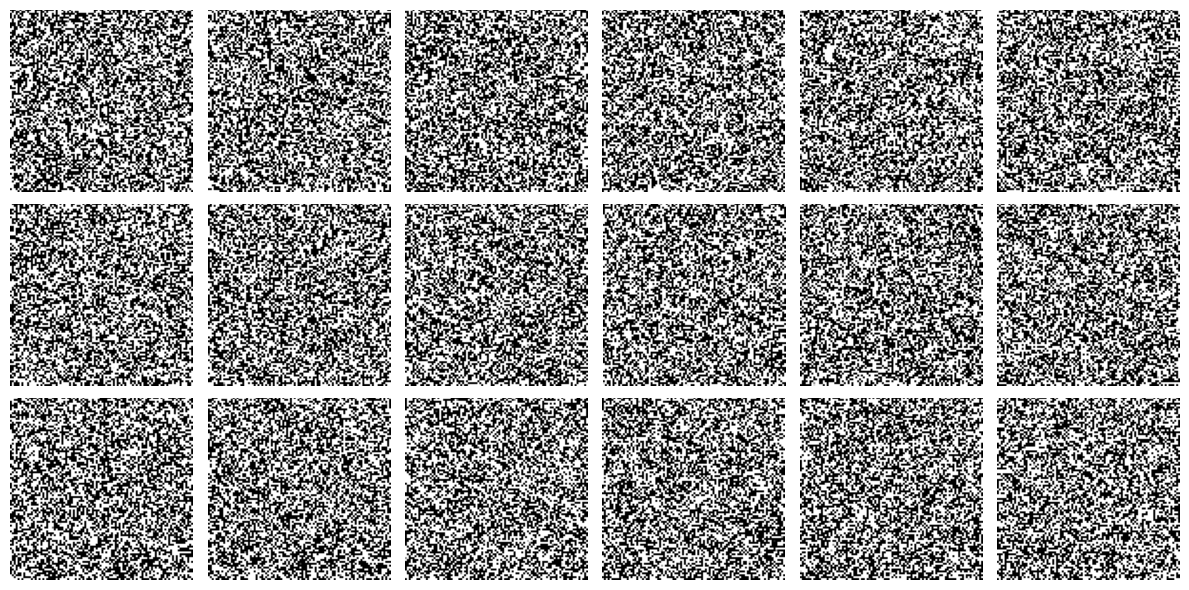


Epoch 1: val_kid improved from inf to 0.00000, saving model to /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models/ddim_implicit_bb_v16X.weights.h5
Epoch 0 logs: {'i_loss': 1.22379732131958, 'n_loss': 0.27274686098098755, 'val_i_loss': 3.495286703109741, 'val_image_loss': 3.627019166946411, 'val_kid': 1.8822518654815212e-08, 'val_n_loss': 0.4202209711074829}

153/153 ━━━━━━━━━━━━━━━━━━━━ 87s 217ms/step - i_loss: 1.8908 - n_loss: 0.3477 - val_i_loss: 3.4953 - val_image_loss: 3.6270 - val_kid: 1.8823e-08 - val_n_loss: 0.4202
Epoch 2/2
152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - i_loss: 0.6655 - n_loss: 0.1946

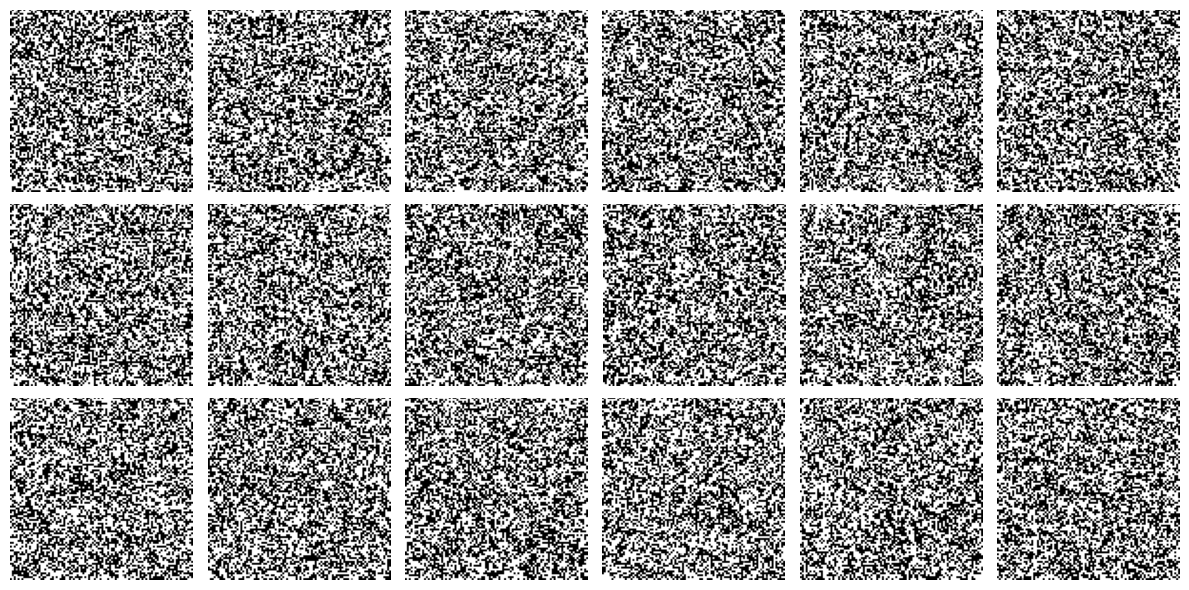


Epoch 2: val_kid did not improve from 0.00000
Epoch 1 logs: {'i_loss': 0.574590265750885, 'n_loss': 0.19622671604156494, 'val_i_loss': 1.6389069557189941, 'val_image_loss': 1.048715591430664, 'val_kid': 1.8822518654815212e-08, 'val_n_loss': 0.38317975401878357}

153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - i_loss: 0.6643 - n_loss: 0.1946 - val_i_loss: 1.6389 - val_image_loss: 1.0487 - val_kid: 1.8823e-08 - val_n_loss: 0.3832
Restoring model weights from the end of the best epoch: 1.


In [ ]:
# ~45mins for A100 on 50 epochs with early stopping
# 50mins for CPU on 10 epochs
LOAD_SAVED = False
if LOAD_SAVED:
  raise SystemExit("Skip model training and load pre-trained model")

# Set mixed precision policy before model creation
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# create and compile the model
model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)

# Create optimizer with mixed precision
base_optimizer = keras.optimizers.AdamW(
    learning_rate=keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=num_epochs * len(train_dataset)
    ),
    weight_decay=weight_decay,
    clipnorm=1.0  # Add gradient clipping
)
optimizer = mixed_precision.LossScaleOptimizer(base_optimizer)

# After each epoch (add to callbacks):
plotting_callback = PlottingCallback()
saving_logs_callback = SaveCallback()
gradient_clipping_callback = GradientClipping()

# Compile with mixed precision optimizer
model.compile(
    optimizer=optimizer,
    loss=keras.losses.Huber(delta=1.0),
    metrics=['kid']
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

model.fit(
    train_dataset,
    epochs=2,
    validation_data=val_dataset,
    callbacks=[
        plotting_callback,
        checkpoint_callback,
        early_stopping_callback,
        gradient_clipping_callback,
        # reduce_LR_on_plateau_callback,
        saving_logs_callback
    ]
)

In [ ]:
# # ~45mins for A100 on 50 epochs with early stopping
# # 50mins for CPU on 10 epochs
# LOAD_SAVED = False
# if LOAD_SAVED:
#   raise SystemExit("Skip model training and load pre-trained model")



# # create and compile the model
# model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)


# optimizer = keras.optimizers.AdamW(
#     learning_rate=keras.optimizers.schedules.CosineDecay( initial_learning_rate=learning_rate,
#                                                           decay_steps=num_epochs * len(train_dataset)),
#     weight_decay=weight_decay,
#     clipnorm=1.0  # Add gradient clipping
# )


# # After each epoch (add to callbacks):

# plotting_callback = PlottingCallback()
# saving_logs_callback = SaveCallback()
# gradient_clipping_callback = GradientClipping()
# # optimizer = OptimizerConfig(learning_rate, weight_decay, num_epochs, train_dataset)


# model.compile( optimizer=optimizer, loss=keras.losses.Huber(delta=1.0),
#                metrics=['kid'])

# # calculate mean and variance of training dataset for normalization
# model.normalizer.adapt(train_dataset)

# # optimizer = keras.optimizers.AdamW(
# #     learning_rate=keras.optimizers.schedules.CosineDecay(
# #         initial_learning_rate=learning_rate,
# #         decay_steps=num_epochs * len(train_dataset)
# #     ),
# #     weight_decay=weight_decay
# # )

# model.fit(
#     train_dataset,
#     epochs=2,
#     validation_data=val_dataset,
#     callbacks=[
#         plotting_callback,
#         checkpoint_callback,
#         early_stopping_callback,
#         gradient_clipping_callback,
#         # reduce_LR_on_plateau_callback,
#         saving_logs_callback

#     ]
# )


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# model.save_weights(checkpoint_path)
print(os.path.exists(checkpoint_path))
print(checkpoint_path)

# import os
# os._exit(0)


# pp = '/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models/ddim_implicit_bb_v6_final.weights.h5'
# print(os.path.exists(pp))

# !ls -lh /content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models


True
/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models/ddim_implicit_bb_v13X.weights.h5


Validation step outputs: {'n_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.42398956>, 'i_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.6958408>, 'kid': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
Epoch 1/2
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - i_loss: 1.5096 - n_loss: 0.2983

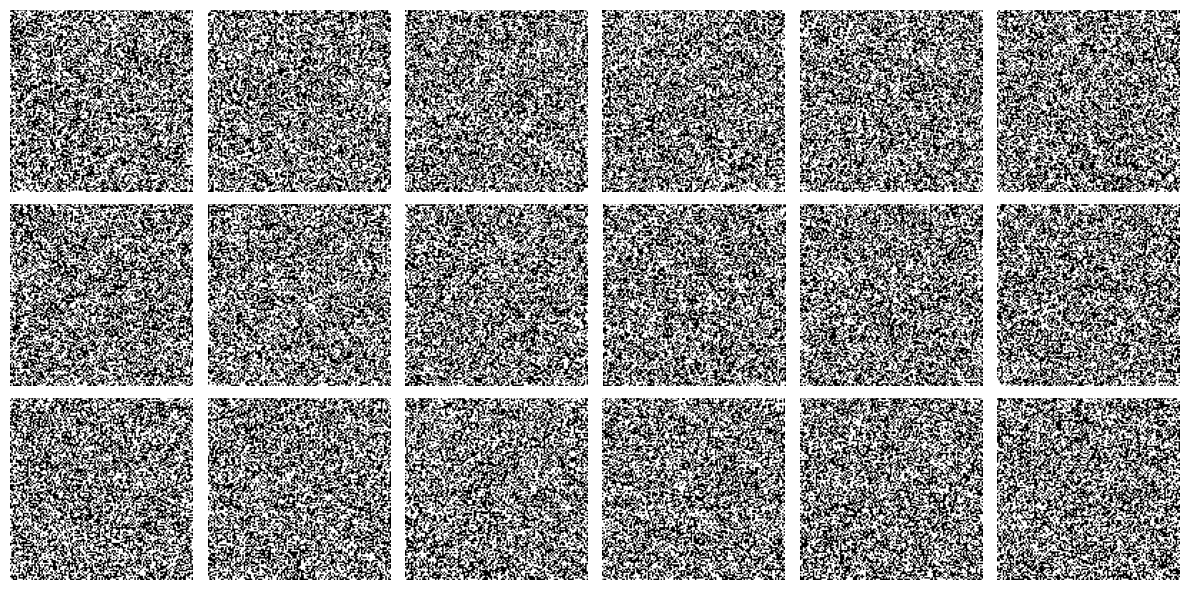

38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 922ms/step - i_loss: 1.4962 - n_loss: 0.2955 - val_i_loss: 1.5345 - val_kid: 2.9140e-07 - val_n_loss: 0.4240 - learning_rate: 4.9988e-04
Epoch 2/2
 1/38 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - i_loss: 0.2069 - n_loss: 0.0990

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_image_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_image_loss` which is not available. Available metrics are: i_loss,n_loss,val_i_loss,val_kid,val_n_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_image_loss` which is not available. Available metrics are: i_loss,n_loss,val_i_loss,val_kid,val_n_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - i_loss: 0.3268 - n_loss: 0.0686

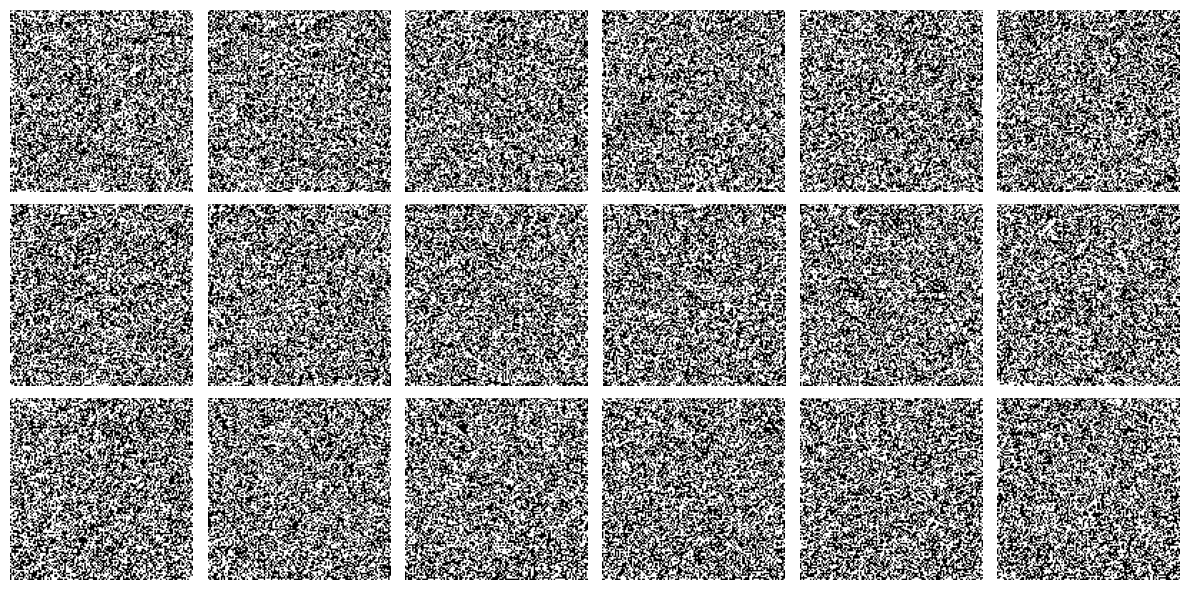

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 407ms/step - i_loss: 0.3270 - n_loss: 0.0684 - val_i_loss: 1.7650 - val_kid: 3.4438e-07 - val_n_loss: 0.4238 - learning_rate: 4.9951e-04


In [ ]:
# def augment_data(image):
#     # Existing augmentations
#     image = tf.image.random_brightness(image, 0.2)
#     image = tf.image.random_contrast(image, 0.8, 1.2)

#     # Add document-specific augmentations
#     image = tf.image.random_jpeg_quality(image, 30, 100) # Simulate compression artifacts
#     random_noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.1)
#     image = image + random_noise  # Add random noise

#     return tf.clip_by_value(image, 0.0, 1.0)

# def augment_data(image):
#     # Brightness/contrast to help model learn cleaner text
#     image = tf.image.random_brightness(image, 0.2)
#     image = tf.image.random_contrast(image, 0.8, 1.2)

#     # Adaptive thresholding to help separate text from background
#     mean = tf.reduce_mean(image)
#     threshold = mean + tf.random.uniform([], -0.1, 0.1)
#     image = tf.where(image > threshold, 1.0, 0.0)

#     return tf.clip_by_value(image, 0.0, 1.0)

# widths = [64, 128, 256, 512]  # Double channel dimensions
# block_depth = 6  # More residual blocks

# # # Create and compile model
# # model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)

# # optimizer = keras.optimizers.AdamW(
# #     learning_rate=keras.optimizers.schedules.CosineDecay(
# #         initial_learning_rate=learning_rate,
# #         decay_steps=num_epochs * len(train_dataset)
# #     ),
# #     weight_decay=weight_decay
# # )

# # model.compile(
# #     optimizer=optimizer,
# #     loss=keras.losses.Huber(delta=1.0)
# # )

# # # Configure model saving
# # model_num = len(os.listdir(f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models'))
# # model_dir = f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models'
# # checkpoint_path = f'{model_dir}/ddim_implicit_bb_v{model_num}_best.weights.h5'
# # final_model_path = f'{model_dir}/ddim_implicit_bb_v{model_num}_final.weights.h5'

# # # Initialize callbacks
# # checkpoint_callback = keras.callbacks.ModelCheckpoint(
# #     filepath=checkpoint_path,
# #     save_weights_only=True,
# #     monitor="val_image_loss",
# #     mode="min",
# #     save_best_only=True,
# #     verbose=1
# # )

# # early_stopping_callback = EarlyStopping(
# #     monitor="val_image_loss",
# #     patience=30,
# #     mode="min",
# #     restore_best_weights=True,
# #     verbose=1
# # )

# # class GradientClipping(keras.callbacks.Callback):
# #     def on_train_batch_begin(self, batch, logs=None):
# #         self.model.optimizer.clip_norm = 1.0

# # # Normalize training data
# # model.normalizer.adapt(train_dataset)

# # # Debug validation output
# # dummy_val_data = next(iter(val_dataset))
# # val_results = model.test_step(dummy_val_data)
# # print("Validation step outputs:", val_results)


# # # Train model
# # history = model.fit(
# #     train_dataset,
# #     epochs=2,
# #     validation_data=val_dataset,
# #     callbacks=[
# #         keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
# #         checkpoint_callback,
# #         early_stopping_callback,
# #         GradientClipping(),
# #         keras.callbacks.ReduceLROnPlateau(
# #             monitor="val_image_loss",
# #             factor=0.2,
# #             patience=15,
# #             min_lr=1e-7,
# #             verbose=1
# #         )
# #     ]
# # )

# # # Save final model weights
# # model.save_weights(final_model_path)

In [ ]:
print(os.path.exists(checkpoint_path))
print(checkpoint_path)
# import os

# # Verify/create directory
# save_dir = f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models'
# os.makedirs(save_dir, exist_ok=True)

# # Print path info
# print("Directory exists:", os.path.exists(save_dir))
# print("Full checkpoint path:", checkpoint_path)
# model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)
# model.normalizer.adapt(train_dataset)
# # checkpoint_path = f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models/ddim_implicit_bb_v4.weights.h5'
# model.load_weights(checkpoint_path)
# model.plot_images()

False
/content/gdrive/MyDrive/bon_vision/genai_cls/wk_7_GAN_n_diffusion_n_realnvp_models/notebooks-1/trained_models/ddim_implicit_bb_models/ddim_implicit_bb_v8X.weights.h5


In [ ]:
model.save_weights(checkpoint_path)
# Before training
print(f"Directory permissions: {os.access(save_dir, os.W_OK)}")

# After training
print("Saving model weights...")
try:
    model.save_weights(checkpoint_path)
    print(f"Successfully saved to: {checkpoint_path}")
except Exception as e:
    print(f"Error saving model: {e}")

print(f"File exists after save: {os.path.exists(checkpoint_path)}")

NameError: name 'save_dir' is not defined

In [ ]:
# ~45mins for A100 on 50 epochs with early stopping
# 50mins for CPU on 10 epochs
LOAD_SAVED = False
if LOAD_SAVED:
  raise SystemExit("Skip model training and load pre-trained model")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import EarlyStopping


# create and compile the model
model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)

# for below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
# model.compile( optimizer=keras.optimizers.AdamW(learning_rate=learning_rate,
#                                                 weight_decay=weight_decay),
#                 loss=keras.losses.MeanAbsoluteError()) # pixelwise mean absolute error is used as loss

optimizer = keras.optimizers.AdamW(
    learning_rate=keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=learning_rate,
        decay_steps=num_epochs * len(train_dataset)
    ),
    weight_decay=weight_decay
)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.Huber(delta=1.0)
)

# Early Stopping bb
# Define Early Stopping
early_stopping_callback = EarlyStopping(  monitor="val_image_loss", #"val_kid",  # Metric to monitor (change if needed)
                                          patience=10,        # Number of epochs with no improvement before stopping
                                          mode="min",         # Direction: "min" for validation loss
                                          restore_best_weights=True,  # Restore weights from the best epoch
                                          verbose=1 )           # Print when stopping occurs


# save the best model based on the validation KID metric
model_num = len(os.listdir(f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models'))
checkpoint_path = f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models/ddim_implicit_bb_v{model_num}.weights.h5'

checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      monitor="val_kid",
                                                      mode="min",
                                                      save_best_only=True,)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# run training and plot generated images periodically
# model.fit(  train_dataset,
#             epochs= 10, #200, # num_epochs = 50, also stops at 50 with early stopping
#             validation_data=val_dataset,
#             callbacks=[ keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
#                         checkpoint_callback, early_stopping_callback, ], )
# Add this before model.fit
# dummy_input = next(iter(train_dataset))
# _ = model(dummy_input)  # This builds the model

model.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
        EarlyStopping(
            monitor="val_image_loss",
            patience=30,
            mode="min",
            restore_best_weights=True,
            verbose=1
        ),
        GradientClipping(),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_image_loss",
            factor=0.2,
            patience=15,
            min_lr=1e-7
        )
    ]
)
# model.fit(
#     train_dataset,
#     epochs=2,#200,
#     validation_data=val_dataset,
#     callbacks=[
#         keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
#         checkpoint_callback,
#         EarlyStopping(
#             monitor="val_image_loss",
#             patience=30,
#             mode="min",
#             restore_best_weights=True,
#             verbose=1
#         ),
#         GradientClipping(),
#         keras.callbacks.ReduceLROnPlateau(
#             monitor="val_image_loss",
#             factor=0.2,
#             patience=15,
#             min_lr=1e-7
#         ),
#         # keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")
#     ]
# )

NotImplementedError: Exception encountered when calling DiffusionModel.call().

[1mModel DiffusionModel does not have a `call()` method implemented.[0m

Arguments received by DiffusionModel.call():
  • args=('tf.Tensor(shape=(16, 128, 128, 1), dtype=float32)',)
  • kwargs=<class 'inspect._empty'>

In [ ]:
LOAD_SAVED = True
# if not LOAD_SAVED:
#   raise SystemExit("Skip model training and load pre-trained model") #, ignore_errors=True)

# load the best model and generate images
checkpoint_path = f'{diffusion_nbs}/trained_models/ddim_implicit_bb_models/ddim_implicit_bb_v3.weights.h5'

model = DiffusionModel(image_size, widths, block_depth, is_gray=GRAY)
model.normalizer.adapt(train_dataset) # adapt the normalizer before using the pre-trained model
model.load_weights(checkpoint_path)
model.plot_images()